In [85]:
import json
import numpy as np
import pandas as pd
import gzip
import math
import matplotlib.pyplot as plt
import random
import sklearn
import string
from collections import defaultdict
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE
import seaborn as sns
import copy

In [10]:
def parseData(fname):
    for l in gzip.open(fname):
        try:
            d = eval(l)
        except:
            continue
        yield d

In [11]:
data = list(parseData("fit_data.json.gz"))

In [12]:
data

[{'fit': 'fit',
  'user_id': '420272',
  'bust size': '34d',
  'item_id': '2260466',
  'weight': '137lbs',
  'rating': '10',
  'rented for': 'vacation',
  'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
  'body type': 'hourglass',
  'review_summary': 'So many compliments!',
  'category': 'romper',
  'height': '5\' 8"',
  'size': 14,
  'age': '28',
  'review_date': 'April 20, 2016'},
 {'fit': 'fit',
  'user_id': '273551',
  'bust size': '34b',
  'item_id': '153475',
  'weight': '132lbs',
  'rating': '10',
  'rented for': 'other',
  'review_text': 'I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event. ',
  'body type': 'straight & narr

In [33]:
df = pd.DataFrame(data)
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


In [36]:
def replace_nan(item):
    if item == 'nan':
        item = 0
    else:
        item = int(item)
    return item

In [34]:
df['rating'] = df['rating'].astype(int)

In [37]:
df['age'] = df['age'].astype(str).map(lambda x: replace_nan(x))

In [42]:
df['weight'] = df['weight'].astype(str).map(lambda x: replace_nan(x.rstrip('lbs')))

In [55]:
def fitLevel(item):
    if item == 'fit':
        return 1
    elif item == 'small':
        return 0
    else:
        return 2

In [56]:
df['fit_level'] = df['fit'].map(lambda x: fitLevel(x))
df['fit_level']

0         1
1         1
2         1
3         1
4         1
         ..
192457    1
192458    1
192459    1
192460    1
192461    1
Name: fit_level, Length: 192462, dtype: int64

In [60]:
df.corr()

,weight,rating,size,age,fit_level
weight,1.000000,-0.010554,0.087851,0.081874,-0.006950
rating,-0.010554,1.000000,-0.036731,-0.034336,0.028364
size,0.087851,-0.036731,1.000000,0.146862,-0.106686
age,0.081874,-0.034336,0.146862,1.000000,-0.013949
fit_level,-0.006950,0.028364,-0.106686,-0.013949,1.000000


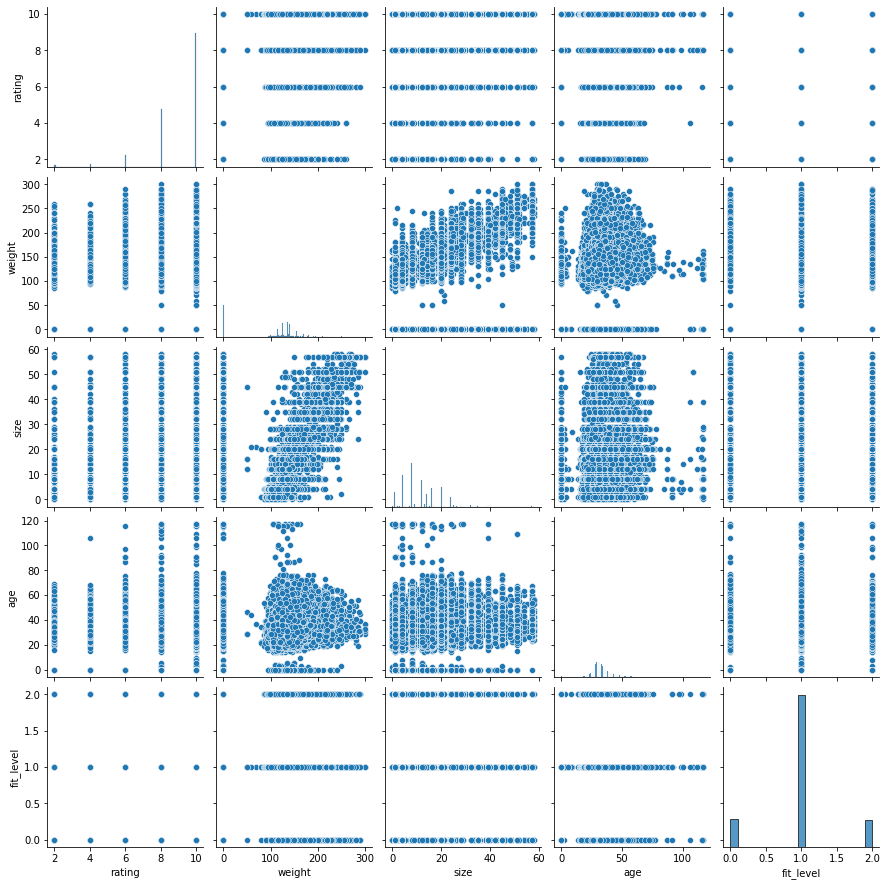

In [63]:
sns.pairplot(df[['rating',"weight", "size", "age", "fit_level"]]) 

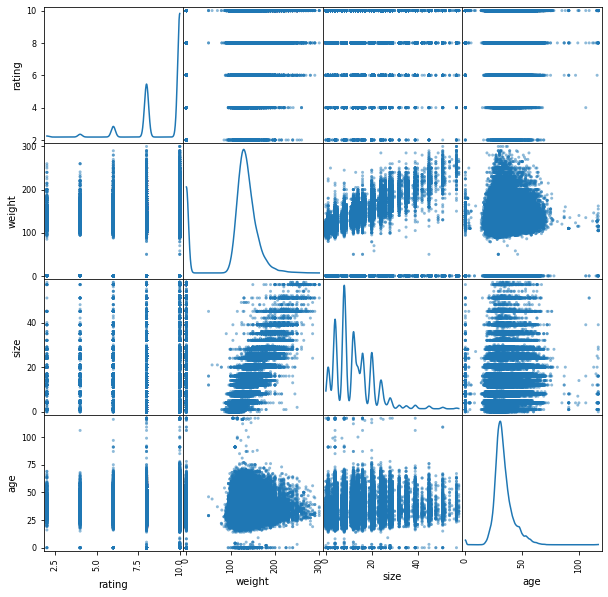

In [44]:
data_for_scattermx = df[['rating',"weight", "size", "age"]]
pd.plotting.scatter_matrix(data_for_scattermx, figsize=(20, 20), diagonal='kde')
plt.show()

In [64]:
df.describe()

,weight,rating,size,age,fit_level
count,192462.000000,192462.000000,192462.000000,192462.000000,192462.000000
mean,116.008121,9.092371,12.245254,33.701188,0.994363
std,53.720737,1.430044,8.495463,8.383927,0.512043
min,0.000000,2.000000,0.000000,0.000000,0.000000
25%,115.000000,8.000000,8.000000,29.000000,1.000000
50%,130.000000,10.000000,12.000000,32.000000,1.000000
75%,145.000000,10.000000,16.000000,37.000000,1.000000
max,300.000000,10.000000,58.000000,117.000000,2.000000


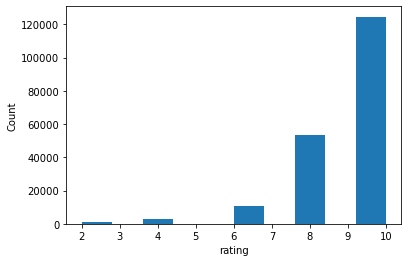

In [72]:
plt.xlabel('rating')
plt.ylabel('Count')
rating_info = plt.hist(df['rating'])

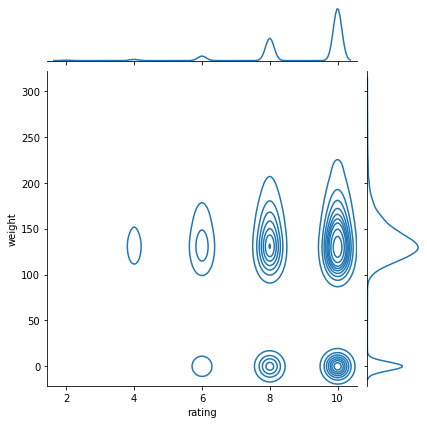

In [77]:
sns.jointplot(x = 'rating', y = 'weight', data = df, kind = 'kde')

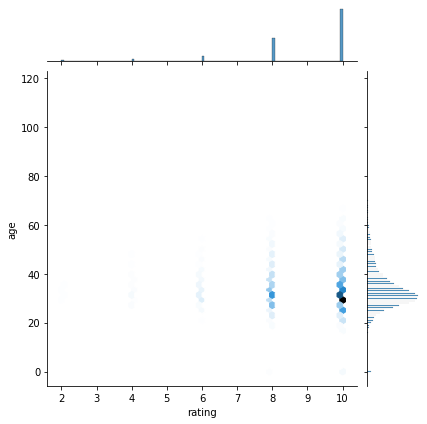

In [78]:
sns.jointplot(x = 'rating', y = 'age', data = df, kind = 'hex')

<AxesSubplot:xlabel='rating', ylabel='size'>

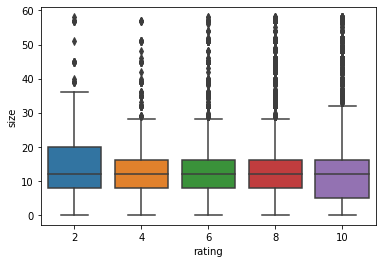

In [82]:
sns.boxplot(x = 'rating', y= 'size', data = df)

In [83]:
df['rating'].value_counts()

10    124537
8      53391
6      10697
4       2791
2       1046
Name: rating, dtype: int64

In [90]:
df.groupby(['rating', 'fit_level']).size()

rating  fit_level
2       0               440
        1               291
        2               315
4       0               992
        1               998
        2               801
6       0              2999
        1              4986
        2              2712
8       0              9634
        1             34967
        2              8790
10      0             11711
        1            100753
        2             12073
dtype: int64

In [91]:
test = list(df.groupby(['rating', 'fit_level']).size())
test

[440,
 291,
 315,
 992,
 998,
 801,
 2999,
 4986,
 2712,
 9634,
 34967,
 8790,
 11711,
 100753,
 12073]

In [92]:
x_ = []
y_ = []
for i in range(5):
    for j in range(3):
        x_.append((i+1)*2)
        y_.append(j)
print(x_)
print(y_)

[2, 2, 2, 4, 4, 4, 6, 6, 6, 8, 8, 8, 10, 10, 10]
[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]


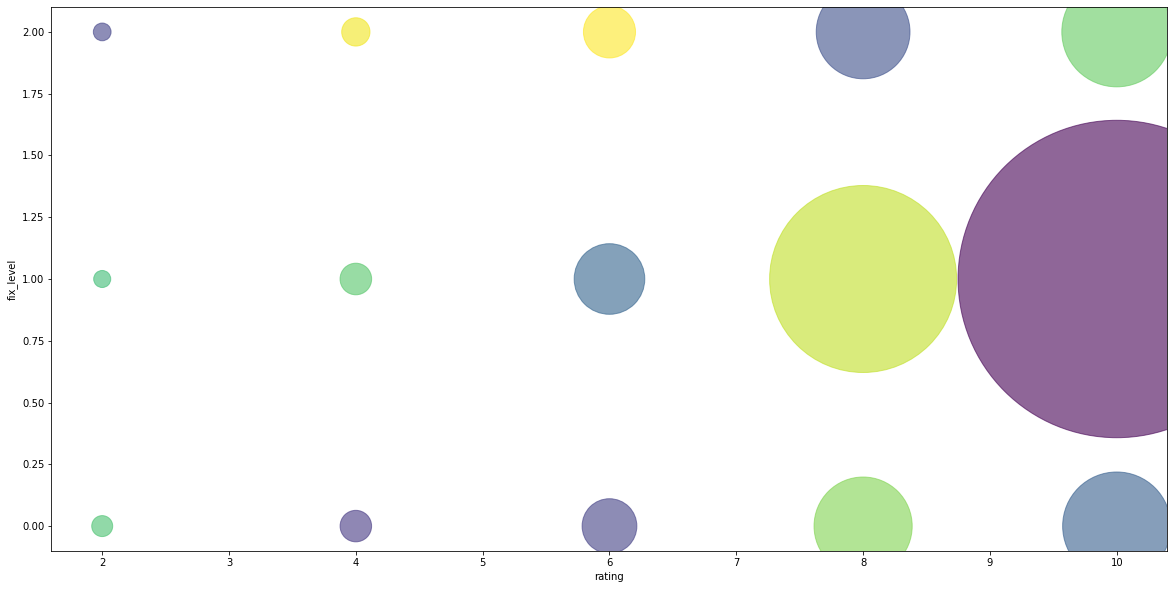

In [101]:
fig = plt.figure(figsize=(20, 10))
colors = np.random.rand(len(x_))
plt.scatter(x_, y_, s=test, c=colors, alpha=0.6)  
plt.xlabel('rating')  
plt.ylabel('fix_level') 
plt.show()


In [ ]:
rating_info = plt.hist(df['rating'])